## Importing Libraries

In [1]:
import io
import os
import wget
import json
import zipfile

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)
# Make sure you are running this in Python3 environment and TFv2.x

2.2.0


## Downloading Dataset

In [3]:
path = os.getcwd()+"\..\data\sarcasm.json"
url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json"
train = wget.download(url, out = path)

100% [..........................................................................] 5643545 / 5643545

## Defining Hyper-Parameters

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

## Separating Sentences and Labels

In [4]:
with open("../data/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Splitting (train-test)

In [5]:
training_sentences = np.array(sentences[0:training_size])
testing_sentences = np.array(sentences[training_size:])

training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

## Tokenizing and Padding

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

# tokenizing and padding train data
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# tokenizing and padding test data
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Building a Model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), # Note the difference between GAP1D() and Flatten() 
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


## Fitting

In [8]:
num_epochs = 30
history = model.fit(
    training_padded, 
    training_labels,
    epochs=num_epochs, 
    verbose=2,
    validation_data=(
        testing_padded, 
        testing_labels
    )
)

Epoch 1/30
625/625 - 4s - loss: 0.5570 - accuracy: 0.7078 - val_loss: 0.3922 - val_accuracy: 0.8371
Epoch 2/30
625/625 - 3s - loss: 0.3085 - accuracy: 0.8759 - val_loss: 0.3451 - val_accuracy: 0.8504
Epoch 3/30
625/625 - 4s - loss: 0.2305 - accuracy: 0.9090 - val_loss: 0.3542 - val_accuracy: 0.8457
Epoch 4/30
625/625 - 4s - loss: 0.1862 - accuracy: 0.9280 - val_loss: 0.3637 - val_accuracy: 0.8509
Epoch 5/30
625/625 - 4s - loss: 0.1553 - accuracy: 0.9428 - val_loss: 0.3915 - val_accuracy: 0.8504
Epoch 6/30
625/625 - 3s - loss: 0.1307 - accuracy: 0.9531 - val_loss: 0.4299 - val_accuracy: 0.8427
Epoch 7/30
625/625 - 4s - loss: 0.1120 - accuracy: 0.9614 - val_loss: 0.4613 - val_accuracy: 0.8430
Epoch 8/30
625/625 - 3s - loss: 0.0952 - accuracy: 0.9690 - val_loss: 0.5053 - val_accuracy: 0.8369
Epoch 9/30
625/625 - 4s - loss: 0.0831 - accuracy: 0.9722 - val_loss: 0.5491 - val_accuracy: 0.8343
Epoch 10/30
625/625 - 4s - loss: 0.0723 - accuracy: 0.9765 - val_loss: 0.6003 - val_accuracy: 0.8316

## Visualising Accuracy and Loss

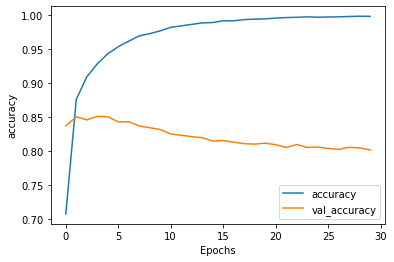

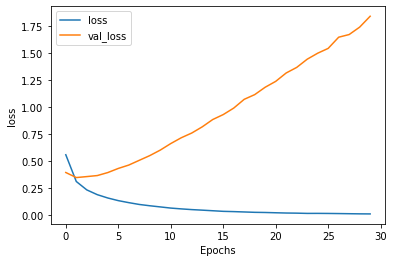

In [9]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## De-Tokenizing

In [10]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print('----De-Tokenized Sentence----')
print(decode_sentence(training_padded[0]),'\n')
print('----Training Sentence----')
print(training_sentences[2],'\n')
print('----Labels----')
print(labels[2])

----De-Tokenized Sentence----
former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 

----Training Sentence----
mom starting to fear son's web series closest thing she will have to grandchild 

----Labels----
1


## Checking Volcabulary Size and Embedding Dimensions

In [11]:
e = model.layers[0]
weights = e.get_weights()[0]
print('vocab_size, embedding_dim: ')
print(weights.shape)

vocab_size, embedding_dim: 
(10000, 16)


## Visualising the Vectors and Metadata

In [12]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

# Downloading vectors and metadata files
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

# These files can be visulaised at: http://projector.tensorflow.org/

<img src="../data/images/IMDB/sarcasm.PNG">

## Testing

In [13]:
sentence = [
    "granny starting to fear spiders in the garden might be real", 
    "game of thrones season finale showing this sunday night"
]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(
    sequences, 
    maxlen=max_length,
    padding=padding_type, 
    truncating=trunc_type
)
print(model.predict(padded))

[[9.9956506e-01]
 [2.6584173e-09]]
